<a target="_blank" href="https://colab.research.google.com/github/juanhuguetgarcia/intro_to_llms/blob/main/intro_to_llms/1_langgraph_connect_llm.ipynb">
  <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
</a>

# Introduction

In this Tutorial, we will learn how to connect to an LLM using langgraph

We will create a graph with one node that connects to an LLM. In today's tutorial we will connect to OpenAI model 'gpt-4o'



# Install required packages

Packages required: langgraph, langchain_openai and langchain_core

In [1]:
# Install LangGraph and langchain packages
%pip install --quiet -U langgraph langchain_openai langchain_core python-dotenv


[notice] A new release of pip is available: 25.0.1 -> 25.1
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


## Set Open AI Key

Set the api key in the .env variable

In [2]:
from dotenv import load_dotenv
load_dotenv()

True

In [3]:
import os
print(os.environ.get("OPENAI_API_KEY")[:10] + "...")

sk-proj-Gx...


## Define the LLM Model

In this tutorial we will use gpt-4o-mini as our LLM

In [4]:
from langchain_openai import ChatOpenAI
llm = ChatOpenAI(model='gpt-4.1')

# define llm Node
def call_llm(message):
    return llm.invoke(message)

In [5]:
response = call_llm("who are you and what is your underlying model version?")

In [6]:
response.content

'I am ChatGPT, an AI language model developed by OpenAI. My underlying model is based on the GPT-4 architecture. My responses are generated using a version of GPT-4 designed for conversational interaction and general knowledge tasks. If you have more technical or detailed questions about how I work, feel free to ask!'

In [7]:
response.response_metadata

{'token_usage': {'completion_tokens': 65,
  'prompt_tokens': 18,
  'total_tokens': 83,
  'completion_tokens_details': {'accepted_prediction_tokens': 0,
   'audio_tokens': 0,
   'reasoning_tokens': 0,
   'rejected_prediction_tokens': 0},
  'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}},
 'model_name': 'gpt-4.1-2025-04-14',
 'system_fingerprint': 'fp_b38e740b47',
 'id': 'chatcmpl-BUCKwosdQSJrRxOO65QnBTv0rO4Jn',
 'service_tier': 'default',
 'finish_reason': 'stop',
 'logprobs': None}

## Create the Graph

Create a node that calls LLM

As there are no other nodes, we will connect the START and the END to this node and compile.

## Understanding LangGraph Components

- **Graph**: A computational structure that represents a workflow with nodes and edges.
  It defines how data flows through different processing steps.

- **Node**: A single processing unit in the graph that performs a specific function.
  In LangGraph, nodes can be LLM calls, tools, or any Python function.

- **Edge**: A connection between nodes that defines the flow of data.
  Edges determine how outputs from one node are passed as inputs to another.

Here's a simple visualization of a graph with nodes and edges:

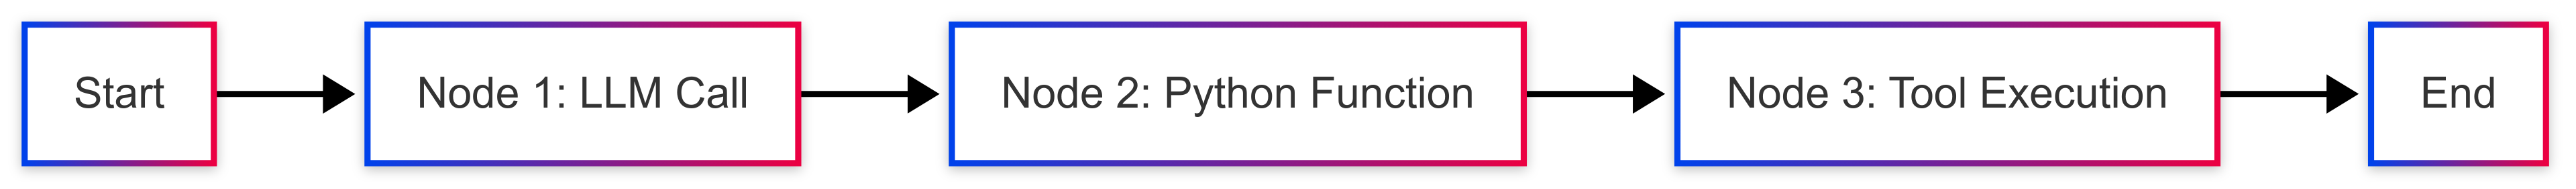


In [8]:
from langgraph.graph import Graph, START, END

# Create a new Graph
workflow = Graph()

# Add the nodes
workflow.add_node("call_llm", call_llm)

# Add the Edges

workflow.add_edge(START, "call_llm")
workflow.add_edge("call_llm", END)

#Run the workflow
app = workflow.compile()

## Visualize the graph

Visualize the graph using display() method

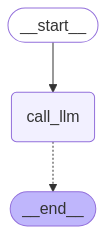

In [9]:
# Visualize your graph
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))

# Test

Test the graph using app.invoke() method.


In [10]:
response=app.invoke("hello")

In [11]:
print(response.content)

Hello! How can I help you today?


In [12]:
app.invoke("How much is 2+2")

AIMessage(content='2 + 2 = **4**', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 9, 'prompt_tokens': 14, 'total_tokens': 23, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4.1-2025-04-14', 'system_fingerprint': 'fp_3b5c2e113e', 'id': 'chatcmpl-BUCL0E8HLllKHJismSNwZKOeEsJCX', 'service_tier': 'default', 'finish_reason': 'stop', 'logprobs': None}, id='run--8984aad7-e522-44f7-93f1-c5521a8c8ba8-0', usage_metadata={'input_tokens': 14, 'output_tokens': 9, 'total_tokens': 23, 'input_token_details': {'audio': 0, 'cache_read': 0}, 'output_token_details': {'audio': 0, 'reasoning': 0}})

## Good, we have the model, the model within a graph, and we can query it so the query is processed.

Now, we will create a simple graph, that forecasts weather as sunny or rainy based on a random number. Its dummy weather forecast function that predicts sunny weather 50% of the time and rainy weather 50% of the time.

🧠 What is “State” in LangGraph?

In LangGraph, state is just a Python dictionary (dict) that stores the data as it moves through the graph.

Think of it like a backpack that gets passed from one node to another. Each node:
* Looks inside the backpack (state)
* Maybe adds something new
* Then passes the updated backpack to the next node

📌 Why It’s Useful
* Nodes don’t just return values — they update state.
* You can track all information passed between nodes.
* You can use branching or memory-like logic.

**Define a starting node. This node just returns a predefined string.**


In [13]:
def weather(state):
    msg = "Let's talk weather..."
    print("[weather] message:", msg)
    return {"message": msg}

We define two more nodes, namely rainy_weather and sunny_weather.

**Remember nodes in langgraph are python functions or langchain runnables.**

In [14]:
def rainy(state: dict) -> dict:
    return {"message": state["message"] + " Its going to rain today. Carry an umbrella."}

In [15]:
def sunny(state: dict) -> dict:
    return {"message": state["message"] + " Its going to be sunny today. Wear sunscreen."}

We will define another function forecast_weather() that will decide whether the weather is sunny or rainy.

In [16]:
import random
from typing import Literal

def forecast_weather(state: dict) -> Literal["sunny", "rainy"]:
    forecast = "sunny" if random.random() < 0.5 else "rainy"
    print("[forecast] message:", forecast)
    return forecast

In [17]:
forecast_weather(dict)

[forecast] message: sunny


'sunny'

## Now, let's create a graph !

In [18]:
from langgraph.graph import StateGraph, START, END

In [19]:
# Create a new Graph
workflow = StateGraph(dict)

In [20]:
workflow.add_node("weather", weather)
workflow.add_node("rainy", rainy)
workflow.add_node("sunny", sunny)

## Now, let's add the edges

* The weather node is the entry point. So we will connect START to weather.
* The weather node decides where to go next based on the forecast_weather function.
* The nodes rainy and sunny are the terminal nodes. So they will be connected to the END node

In [21]:
workflow.add_edge(START, "weather")

In [22]:
workflow.add_conditional_edges("weather", forecast_weather)
workflow.add_edge("rainy", END)
workflow.add_edge("sunny", END)

In [23]:
#Compile the graph
app = workflow.compile()

In [24]:
app.invoke("hey")

[weather] message: Let's talk weather...
[forecast] message: rainy


{'message': "Let's talk weather... Its going to rain today. Carry an umbrella."}

Visualize the flow ! (not working due to a change of version ?)

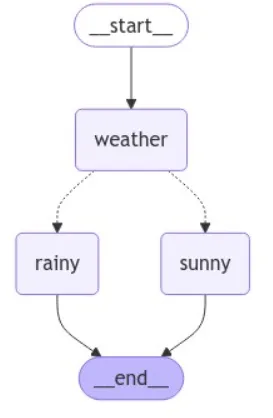

In [63]:
import random
from typing import Literal
from langgraph.graph import StateGraph, END

# --- Node functions ---

def forecast_weather(state: dict) -> Literal["sunny", "rainy"]:
    return "sunny" if random.random() < 0.5 else "rainy"

def weather(state: dict) -> dict:
    return {"message": "Let's talk weather..."}

def sunny(state: dict) -> dict:
    return {"message": state["message"] + " It's sunny!"}

def rainy(state: dict) -> dict:
    return {"message": state["message"] + " It's rainy!"}

# --- Graph ---
graph = StateGraph(dict)
graph.add_node("weather", weather)
graph.add_node("sunny", sunny)
graph.add_node("rainy", rainy)

graph.set_entry_point("weather")
graph.add_conditional_edges("weather", forecast_weather, {
    "sunny": "sunny",
    "rainy": "rainy"
})
graph.add_edge("sunny", END)
graph.add_edge("rainy", END)

app = graph.compile()

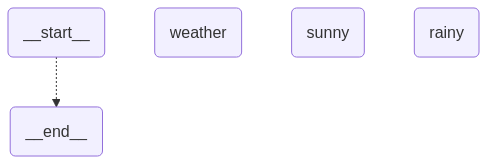

In [64]:
from IPython.display import Image, display
display(Image(app.get_graph().draw_mermaid_png()))